In [1]:
#!pip install ijson
# Import necessary pacakges
import ijson
import numpy as np
import pandas as pd
import seaborn as sns

In [5]:
%time

# Extract data in an easily parsable format --> condense the data to only needed pieces.
# Note that chunk size can be varied to accomodate your local performance.
# Smaller chunk sizes lower memory usage at the cost of longer processing times.
# (Side Note: Chunk processing could also pretty easily be done in parallel, but not implemented here)

f = open("data_exercise.json")
chunksize = 100000

dau = {}
isFirsts = {}
utms = {}

mlist = []
for item in ijson.items(f, "item"):
    mlist += [item]
    
    # Get First Timers as they are read.
    if item['isFirst'] == True:
        try:
            isFirsts[item['date']] = list(set(isFirsts[item['date']] + [item['uid']]))
        except KeyError:
            isFirsts[item['date']] = [item['uid']]
    
    # Process chunk of data
    if len(mlist) >= chunksize:
        df = pd.DataFrame(mlist)    
        
        # Get UTMs by ID
        dfu = df.groupby('utmSource').apply(lambda x: x['uid'].unique())
        for utm, ids in dfu.to_dict().items():
            try:
                utms[utm] = list(set(utms[utm] + np.ndarray.tolist(ids)))
            except KeyError:
                utms[utm] = np.ndarray.tolist(ids)
        
        # Get Dates by ID
        dfd = df.groupby('date').apply(lambda x: x['uid'].unique())
        for date, ids in dfd.to_dict().items():
            try:
                dau[date] = list(set(dau[date] + np.ndarray.tolist(ids)))
            except KeyError:
                dau[date] = np.ndarray.tolist(ids)

        mlist = []

CPU times: user 21 µs, sys: 6 µs, total: 27 µs
Wall time: 65.8 µs


In [27]:
dfs = pd.DataFrame([dau.keys(), dau.values()]).T
dfs.columns=['Date','UIDs']
dfs = dfs.sort_values('Date').reset_index(drop=True)
dfs['Daily_Active_Users'] = dfs['UIDs'].apply(lambda x: len(x))

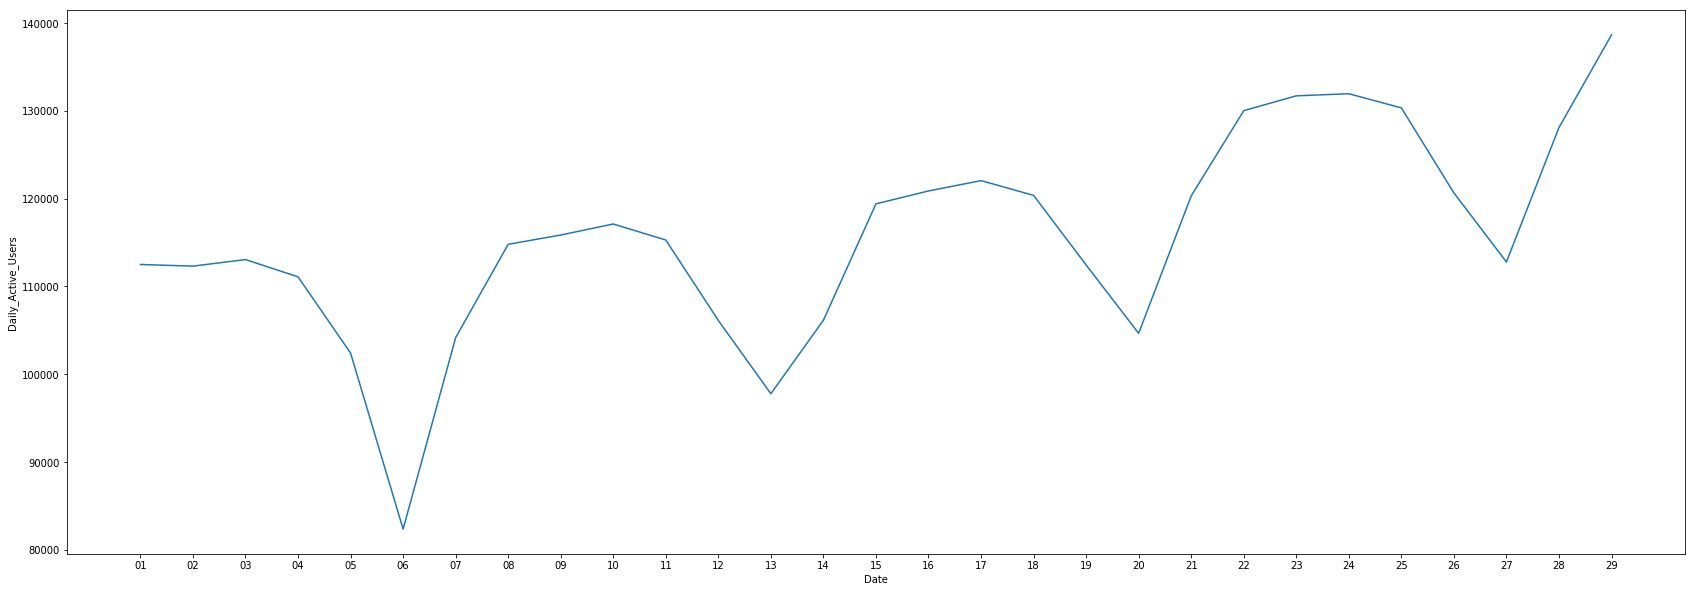

In [29]:
%matplotlib inline
import matplotlib.pyplot as plt

dims = (29, 10)
fig, ax = plt.subplots(figsize=dims)
sns.lineplot(dfs['Date'].apply(lambda x: x[-2:]), dfs['Daily_Active_Users'], ax=ax)

In [31]:
# Cohorts for Feb 4, Feb 10, Feb 14
c4 = isFirsts['2016-02-04']
c10 = isFirsts['2016-02-10']
c14 = isFirsts['2016-02-14']

dfs['c4_retention'] = dfs['UIDs'].apply(lambda x: len(set(x).intersection(c4))/len(c4))
dfs['c10_retention'] = dfs['UIDs'].apply(lambda x: len(set(x).intersection(c10))/len(c10))
dfs['c14_retention'] = dfs['UIDs'].apply(lambda x: len(set(x).intersection(c14))/len(c14))

<Figure size 432x288 with 0 Axes>

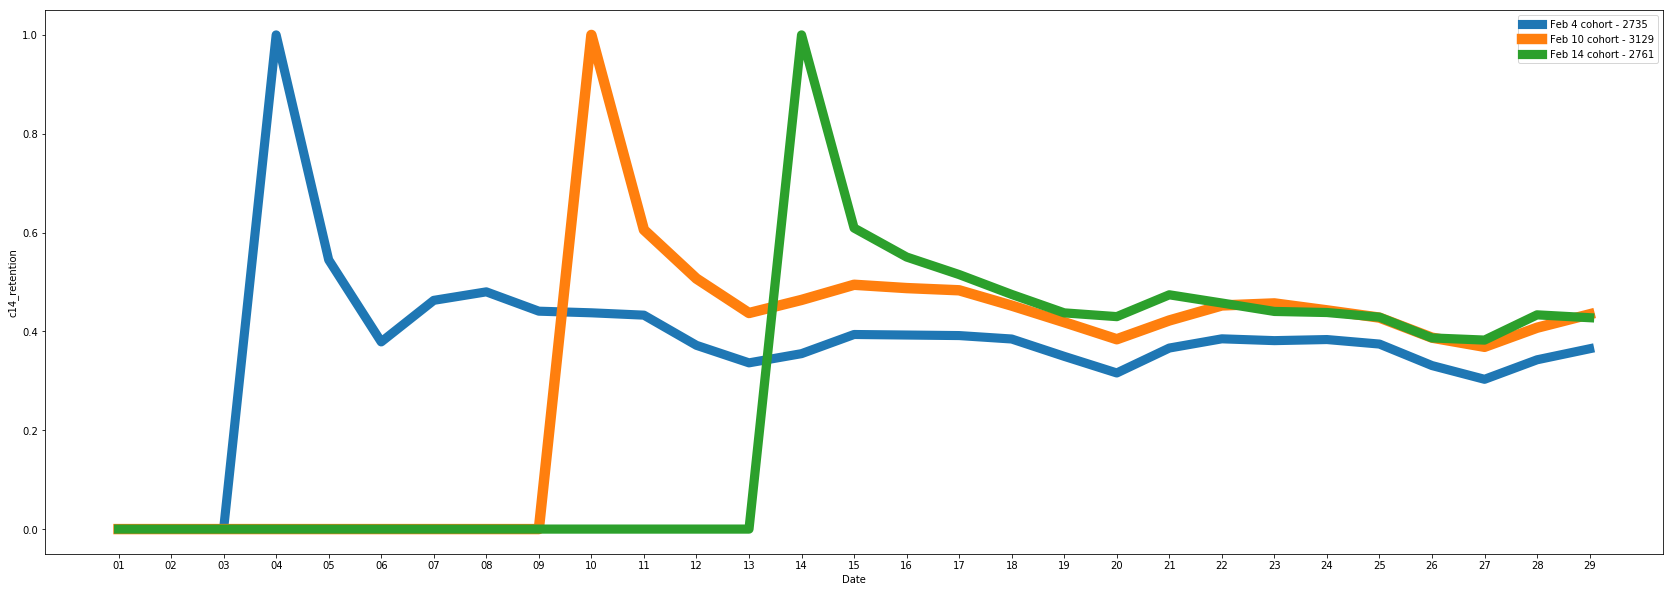

In [55]:
%matplotlib inline
plt.clf()
dims = (29, 10)
fig, ax = plt.subplots(figsize=dims)

sns.lineplot(dfs['Date'].apply(lambda x: x[-2:]), dfs['c4_retention'], ax=ax, linewidth=len(c4)/300)
sns.lineplot(dfs['Date'].apply(lambda x: x[-2:]), dfs['c10_retention'], ax=ax, linewidth=len(c10)/300)
sns.lineplot(dfs['Date'].apply(lambda x: x[-2:]), dfs['c14_retention'], ax=ax, linewidth=len(c14)/300)

ax.legend(handles=ax.lines[::1], labels=["Feb 4 cohort - {}".format(len(c4)),
                                         "Feb 10 cohort - {}".format(len(c10)),
                                         "Feb 14 cohort - {}".format(len(c14))])

In [ ]:
#dfs.to_csv('DailyActiveUsers.csv')

In [87]:
dfu2 = pd.DataFrame([utms.keys(), utms.values()]).T
dfu2.columns=['UTM Source','UIDs']
dfu2['UID_len'] = dfu2['UIDs'].apply(lambda x: len(x))
#dfu2.to_csv('DailyActiveUsers.csv')

In [96]:
best = list(dfu2[dfu2['UID_len'] == max(dfu2['UID_len'])]['UTM Source'].values)
worst = list(dfu2[dfu2['UID_len'] == min(dfu2['UID_len'])]['UTM Source'].values)

In [97]:
best

['Biznesowe+Rewolucje']

In [92]:
worst

['LinkedIn_org',
 "Sarah+Doody's+UX+Notebook",
 'SummerInvite',
 'Twitter_org',
 'bing',
 'sendgrid.com',
 'shmoop_logo',
 'brand',
 'cafemom.com',
 'shmoop_right',
 'gsp',
 'Sticky Blogging Secrets',
 'taboola',
 'blogger_outreach',
 'display',
 'card']